In [30]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15820309451170284163
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3656384512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16587247002932502852
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [31]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import zipfile
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob

In [32]:
base_skin_dir = os.path.join('C:/Users/USER/skin_cancer/')

In [33]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [34]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
4544,HAM_0001476,ISIC_0025343,nv,follow_up,35.0,male,lower extremity,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,4
7527,HAM_0006158,ISIC_0033096,nv,histo,40.0,male,back,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,4
2821,HAM_0004495,ISIC_0024743,bcc,histo,65.0,female,lower extremity,C:/Users/USER/skin_cancer\HAM10000_images_part...,Basal cell carcinoma,1


In [35]:
# dx의 라벨을 만들어 줍니다.
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type_idx'] = pd.Categorical(tile_df['dx']).codes

In [36]:
tile_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/USER/skin_cancer\HAM10000_images_part...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/USER/skin_cancer\HAM10000_images_part...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/USER/skin_cancer\HAM10000_images_part...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/USER/skin_cancer\HAM10000_images_part...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/USER/skin_cancer\HAM10000_images_part...,Benign keratosis-like lesions,2


In [37]:
# age에 NAN 값이 있다는 것을 확인
tile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


In [38]:
# age에 NULL 값에 age 평균 값 채워넣기
tile_df['age'] = tile_df['age'].fillna(tile_df['age'].mean())

In [39]:
# 모델을 돌릴시에 숫자형이면 인식이 안되어
# object로 바꾸어 줍니다.
tile_df['cell_type_idx']=tile_df['cell_type_idx'].astype('object')
tile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            10015 non-null  float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  object 
dtypes: float64(1), object(9)
memory usage: 782.5+ KB


In [40]:
# NULL 값이 없다는 것을 확인
tile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            10015 non-null  float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  object 
dtypes: float64(1), object(9)
memory usage: 782.5+ KB


In [41]:
tile_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/USER/skin_cancer\HAM10000_images_part...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/USER/skin_cancer\HAM10000_images_part...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/USER/skin_cancer\HAM10000_images_part...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/USER/skin_cancer\HAM10000_images_part...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/USER/skin_cancer\HAM10000_images_part...,Benign keratosis-like lesions,2


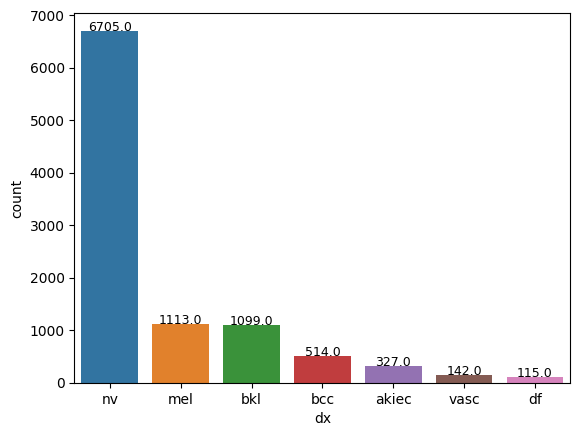

In [42]:
# 프로젝트의 주제가 피부암 종류를 파악하는 것으로 
# 피부암 종류를 countplot을 통해 시각화
# nv가 엄청 많은 것을 확인 했지만 큰 문제가 되지 않는다고 판단하며
# 균형을 맞추지는 않았습니다.
ax = sns.countplot(x = 'dx', data = tile_df,dodge = True,
                  order = tile_df['dx'].value_counts().index)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

In [43]:
# 스케일링 미리 해주기
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale= 1./255)

In [44]:
# tile_df에서 데이터를 분할 합니다.
from sklearn.model_selection import train_test_split

# 9:1 테스트와 훈련 데이터 나누기
x_train, x_test = train_test_split(tile_df, test_size=0.1, random_state = 777)

In [45]:
print(x_train.shape)
print(x_test.shape)

(9013, 10)
(1002, 10)


In [46]:
# 9:1으로 x_train과 x_val 나누기
x_train, x_val = train_test_split(x_train,test_size=0.1, random_state=777)

In [47]:
print(f'훈련 데이터 {x_train.shape}')
print(f'검증 데이터 {x_val.shape}')

훈련 데이터 (8111, 10)
검증 데이터 (902, 10)


In [48]:
# dx를 통하여 라벨 지정
# x_train은 train_generator로 x_val은 val_generator로 x_train은 val_generator로 지정해 줍니다.
# x_col의 해당 이미지 파일 경로로 지정
# color_mod는 'rgb', class_mode는 categorical로 지정
# seed는 42, batch_size는 32로 지정

batch_size=32

train_generator = train_datagen.flow_from_dataframe(
    dataframe = x_train,
    directory='',
    x_col = 'path',
    y_col = 'dx',
    target_size = (150, 150),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle=True,
    seed=42)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = x_val,
    directory = '',
    x_col = 'path',
    y_col = 'dx',
    target_size = (150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 8111 validated image filenames belonging to 7 classes.
Found 902 validated image filenames belonging to 7 classes.


In [50]:
# test_df를 활용하여 test_generator 생성
# 단, 여기서는 정확한 평가를 위해 
# label를 삭제
# shuffle은 하면 안 되며 test이기에 라벨을 붙여서는 안 됩니다.
test_datagen = ImageDataGenerator(rescale= 1./255)

test_generator = train_datagen.flow_from_dataframe(
    dataframe = x_test,
    directory=None,
    x_col = 'path',
    y_col = None,
    target_size = (150, 150),
    color_mode = 'rgb',
    class_mode = None,
    batch_size = batch_size,
    shuffle = False)

Found 1002 validated image filenames.


In [51]:
# 결과 값이 가장 좋은 드롭아웃을 사용
# 이미지 사이는 150으로 고정
# 다중 분류이기에 softmax와 손실 함수는 categorical_crossentropy를 사용
# 클래스가 7개 이기에 출력층을 7개 생성
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 3, padding ='same',
                 activation = 'relu', input_shape = (150, 150, 3)))
model.add(Conv2D(filters = 32, kernel_size = 3, padding ='same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 16, kernel_size = 3, padding ='same',
                 activation = 'relu', input_shape = (150, 150, 3)))
model.add(Conv2D(filters = 16, kernel_size = 3, padding ='same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 16, kernel_size = 3, padding ='same',
                 activation = 'relu'))
model.add(Conv2D(filters =16, kernel_size = 3, padding ='same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = 3, padding ='same',
                 activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding ='same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 16, kernel_size = 3, padding ='same',
                 activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = 3, padding ='same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 16, kernel_size = 3, padding ='same',
                 activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = 3, padding ='same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 32, kernel_size = 3, padding ='same',
                 activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = 3, padding ='same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2, padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(7, activation = 'softmax'))

model.compile(optimizer = Adam(1e-4),
              loss = 'categorical_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 16)        4624      
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 16)        2320      
                                                        

In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# 검증 데이터 손실(val_loss)이 증가하면, 
# 과적합 징후므로 검증 데이터 손실이 5회 증가하면 
# 학습을 조기 종료(Early Stopping)합니다. 

# Q1_model.h5에 정확도가 높은 모델 저장 
mc = ModelCheckpoint('Q4_model.h5', 
                     monitor='val_acc', mode='max', 
                     verbose=2, save_best_only=True)

In [23]:
history = model.fit(train_generator,
                    epochs =150 ,
                    batch_size = 16,
                    callbacks=[mc],
                    validation_data = val_generator)

Epoch 1/150
254/254 [==============================] - ETA: 0s - loss: 1.2309 - acc: 0.6732
Epoch 00001: val_acc improved from -inf to 0.64302, saving model to Q4_model.h5
254/254 [==============================] - 52s 167ms/step - loss: 1.2309 - acc: 0.6732 - val_loss: 1.3663 - val_acc: 0.6430
Epoch 2/150
254/254 [==============================] - ETA: 0s - loss: 1.0250 - acc: 0.6734
Epoch 00002: val_acc did not improve from 0.64302
254/254 [==============================] - 39s 154ms/step - loss: 1.0250 - acc: 0.6734 - val_loss: 1.2635 - val_acc: 0.6430
Epoch 3/150
254/254 [==============================] - ETA: 0s - loss: 1.0061 - acc: 0.6734
Epoch 00003: val_acc did not improve from 0.64302
254/254 [==============================] - 39s 152ms/step - loss: 1.0061 - acc: 0.6734 - val_loss: 1.1631 - val_acc: 0.6430
Epoch 4/150
254/254 [==============================] - ETA: 0s - loss: 0.9860 - acc: 0.6734
Epoch 00004: val_acc did not improve from 0.64302
254/254 [=====================

Epoch 31/150
254/254 [==============================] - ETA: 0s - loss: 0.7827 - acc: 0.7063
Epoch 00031: val_acc did not improve from 0.70067
254/254 [==============================] - 39s 151ms/step - loss: 0.7827 - acc: 0.7063 - val_loss: 0.8490 - val_acc: 0.6951
Epoch 32/150
254/254 [==============================] - ETA: 0s - loss: 0.7770 - acc: 0.7025
Epoch 00032: val_acc did not improve from 0.70067
254/254 [==============================] - 38s 150ms/step - loss: 0.7770 - acc: 0.7025 - val_loss: 0.8418 - val_acc: 0.6951
Epoch 33/150
254/254 [==============================] - ETA: 0s - loss: 0.7769 - acc: 0.7047
Epoch 00033: val_acc did not improve from 0.70067
254/254 [==============================] - 39s 153ms/step - loss: 0.7769 - acc: 0.7047 - val_loss: 0.8332 - val_acc: 0.6907
Epoch 34/150
254/254 [==============================] - ETA: 0s - loss: 0.7751 - acc: 0.7117
Epoch 00034: val_acc did not improve from 0.70067
254/254 [==============================] - 39s 152ms/ste

Epoch 92/150
254/254 [==============================] - ETA: 0s - loss: 0.6399 - acc: 0.7633
Epoch 00092: val_acc did not improve from 0.73614
254/254 [==============================] - 38s 150ms/step - loss: 0.6399 - acc: 0.7633 - val_loss: 0.7353 - val_acc: 0.7284
Epoch 93/150
254/254 [==============================] - ETA: 0s - loss: 0.6399 - acc: 0.7622
Epoch 00093: val_acc did not improve from 0.73614
254/254 [==============================] - 39s 152ms/step - loss: 0.6399 - acc: 0.7622 - val_loss: 0.7672 - val_acc: 0.7217
Epoch 94/150
254/254 [==============================] - ETA: 0s - loss: 0.6439 - acc: 0.7627
Epoch 00094: val_acc did not improve from 0.73614
254/254 [==============================] - 38s 151ms/step - loss: 0.6439 - acc: 0.7627 - val_loss: 0.7781 - val_acc: 0.7217
Epoch 95/150
254/254 [==============================] - ETA: 0s - loss: 0.6297 - acc: 0.7680
Epoch 00095: val_acc did not improve from 0.73614
254/254 [==============================] - 39s 154ms/ste

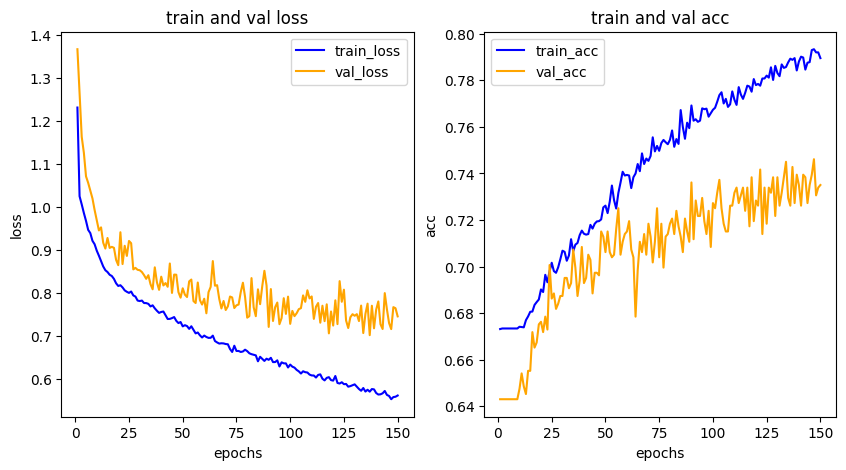

In [24]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

In [53]:
# ImageDataGenerator를 이용한 이미지 증식
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 30,
                                   fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale=1./255) 

In [54]:
# dx를 통하여 라벨 지정
# x_train은 train_generator로 x_val은 val_generator로 x_train은 val_generator로 지정해 줍니다.
# x_col의 해당 이미지 파일 경로로 지정
# color_mod는 'rgb', class_mode는 categorical로 지정
# seed는 42, batch_size는 32로 지정


batch_size=32

train_generator = train_datagen.flow_from_dataframe(
    dataframe = x_train,
    directory='',
    x_col = 'path',
    y_col = 'dx',
    target_size = (150, 150),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle=True,
    seed=42)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = x_val,
    directory = '',
    x_col = 'path',
    y_col = 'dx',
    target_size = (150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 8111 validated image filenames belonging to 7 classes.
Found 902 validated image filenames belonging to 7 classes.


In [55]:
# 데이터 전이 모델 중 MobileNet 불러오기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D ,MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

# imagenet을 학습한 이미지 가져옴
v16 = VGG16(weights = 'imagenet', input_shape = (150,150,3), include_top = False)
v16.summary()

58900480/58889256 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [57]:
# 동결 해제
for layer in v16.layers[:-4]:
    layer.trainable = False

In [58]:
# 모델 쌓기
model = Sequential()
model.add(v16)
model.add(Flatten())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                524352    
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                      

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# 검증 데이터 손실(val_loss)이 증가하면, 
# 과적합 징후므로 검증 데이터 손실이 5회 증가하면 
# 학습을 조기 종료(Early Stopping)합니다. 

# best_mask_model.h5에 정확도가 높은 모델 저장
mc = ModelCheckpoint('best_skin_model4.h5', 
                     monitor='val_acc', mode='max', 
                     verbose=2, save_best_only=True)

In [31]:
model.compile(optimizer = Adam(1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])


history = model.fit(train_generator,
                    epochs = 100,
                    validation_data = val_generator,
                    callbacks=[mc],
                    validation_steps = 2)

Epoch 1/100
254/254 [==============================] - ETA: 0s - loss: 1.1315 - acc: 0.6539
Epoch 00001: val_acc improved from -inf to 0.70312, saving model to best_skin_model4.h5
254/254 [==============================] - 67s 249ms/step - loss: 1.1315 - acc: 0.6539 - val_loss: 0.8023 - val_acc: 0.7031
Epoch 2/100
254/254 [==============================] - ETA: 0s - loss: 0.8464 - acc: 0.7277
Epoch 00002: val_acc improved from 0.70312 to 0.78125, saving model to best_skin_model4.h5
254/254 [==============================] - 58s 229ms/step - loss: 0.8464 - acc: 0.7277 - val_loss: 0.8476 - val_acc: 0.7812
Epoch 3/100
254/254 [==============================] - ETA: 0s - loss: 0.7526 - acc: 0.7443
Epoch 00003: val_acc did not improve from 0.78125
254/254 [==============================] - 58s 228ms/step - loss: 0.7526 - acc: 0.7443 - val_loss: 1.0279 - val_acc: 0.6562
Epoch 4/100
254/254 [==============================] - ETA: 0s - loss: 0.7005 - acc: 0.7560
Epoch 00004: val_acc did not im

Epoch 62/100
254/254 [==============================] - ETA: 0s - loss: 0.1906 - acc: 0.9305
Epoch 00062: val_acc did not improve from 0.87500
254/254 [==============================] - 57s 222ms/step - loss: 0.1906 - acc: 0.9305 - val_loss: 1.0657 - val_acc: 0.7656
Epoch 63/100
254/254 [==============================] - ETA: 0s - loss: 0.1945 - acc: 0.9321
Epoch 00063: val_acc did not improve from 0.87500
254/254 [==============================] - 59s 232ms/step - loss: 0.1945 - acc: 0.9321 - val_loss: 0.5744 - val_acc: 0.8438
Epoch 64/100
254/254 [==============================] - ETA: 0s - loss: 0.1743 - acc: 0.9370
Epoch 00064: val_acc did not improve from 0.87500
254/254 [==============================] - 56s 221ms/step - loss: 0.1743 - acc: 0.9370 - val_loss: 0.6745 - val_acc: 0.8438
Epoch 65/100
254/254 [==============================] - ETA: 0s - loss: 0.1803 - acc: 0.9358
Epoch 00065: val_acc did not improve from 0.87500
254/254 [==============================] - 56s 221ms/ste

Epoch 93/100
254/254 [==============================] - ETA: 0s - loss: 0.1129 - acc: 0.9603
Epoch 00093: val_acc did not improve from 0.89062
254/254 [==============================] - 59s 232ms/step - loss: 0.1129 - acc: 0.9603 - val_loss: 0.8956 - val_acc: 0.7812
Epoch 94/100
254/254 [==============================] - ETA: 0s - loss: 0.1165 - acc: 0.9587
Epoch 00094: val_acc did not improve from 0.89062
254/254 [==============================] - 59s 233ms/step - loss: 0.1165 - acc: 0.9587 - val_loss: 1.0426 - val_acc: 0.7969
Epoch 95/100
254/254 [==============================] - ETA: 0s - loss: 0.1159 - acc: 0.9626
Epoch 00095: val_acc did not improve from 0.89062
254/254 [==============================] - 59s 232ms/step - loss: 0.1159 - acc: 0.9626 - val_loss: 0.7384 - val_acc: 0.8750
Epoch 96/100
254/254 [==============================] - ETA: 0s - loss: 0.1192 - acc: 0.9581
Epoch 00096: val_acc did not improve from 0.89062
254/254 [==============================] - 59s 231ms/ste

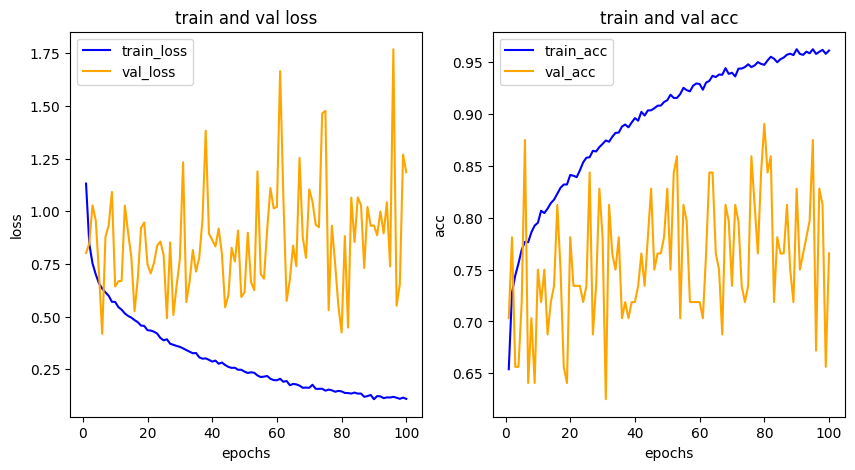

In [32]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

In [169]:
import tensorflow as tf
model = tf.keras.models.load_model('best_skin_model4.h5')

In [170]:
# test_generator를 이용하여 예측 모델을 만들어 줍니다.
result = model.predict(test_generator)

In [171]:
# 예측 값을 수치형으로 바꾸어 줍니다.
pred = []

for i in result:
    pred.append(i.argmax())

In [172]:
# 예측값을 x_test에 넣어 비교하고 확인 합니다.
x_test['pred'] = pred

In [173]:
# 'cell_type_idx'를 수치형으로 바꾸어 예측값과 동일하게 해줍니다.
x_test['cell_type_idx'] = x_test['cell_type_idx'].astype('int8')

In [174]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1002 entries, 3025 to 7636
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      1002 non-null   object 
 1   image_id       1002 non-null   object 
 2   dx             1002 non-null   object 
 3   dx_type        1002 non-null   object 
 4   age            1002 non-null   float64
 5   sex            1002 non-null   object 
 6   localization   1002 non-null   object 
 7   path           1002 non-null   object 
 8   cell_type      1002 non-null   object 
 9   cell_type_idx  1002 non-null   int8   
 10  pred           1002 non-null   int64  
dtypes: float64(1), int64(1), int8(1), object(8)
memory usage: 119.4+ KB


In [175]:
x_test

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,pred
3025,HAM_0004140,ISIC_0028298,nv,follow_up,45.0,male,upper extremity,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
2399,HAM_0004542,ISIC_0027256,vasc,consensus,0.0,female,back,C:/Users/USER/skin_cancer\HAM10000_images_part...,Vascular lesions,6,6
439,HAM_0004889,ISIC_0026714,bkl,histo,75.0,male,upper extremity,C:/Users/USER/skin_cancer\HAM10000_images_part...,Benign keratosis-like lesions,2,5
1012,HAM_0001735,ISIC_0028587,bkl,consensus,80.0,male,back,C:/Users/USER/skin_cancer\HAM10000_images_part...,Benign keratosis-like lesions,2,2
2748,HAM_0000457,ISIC_0026855,bcc,histo,70.0,female,chest,C:/Users/USER/skin_cancer\HAM10000_images_part...,Basal cell carcinoma,1,5
...,...,...,...,...,...,...,...,...,...,...,...
2541,HAM_0005947,ISIC_0027998,bcc,histo,65.0,female,upper extremity,C:/Users/USER/skin_cancer\HAM10000_images_part...,Basal cell carcinoma,1,5
4553,HAM_0006087,ISIC_0032094,nv,follow_up,45.0,male,back,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
4155,HAM_0005534,ISIC_0032075,nv,follow_up,50.0,male,back,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,6
5007,HAM_0006322,ISIC_0030309,nv,follow_up,55.0,male,foot,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5


In [176]:
#x_test.to_csv('네번쨰 모델 결과.csv')

In [177]:
condition = (x_test.cell_type_idx==x_test.pred) # 조건식 작성
yes_df=x_test[condition]
yes_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,pred
3025,HAM_0004140,ISIC_0028298,nv,follow_up,45.0,male,upper extremity,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
2399,HAM_0004542,ISIC_0027256,vasc,consensus,0.0,female,back,C:/Users/USER/skin_cancer\HAM10000_images_part...,Vascular lesions,6,6
1012,HAM_0001735,ISIC_0028587,bkl,consensus,80.0,male,back,C:/Users/USER/skin_cancer\HAM10000_images_part...,Benign keratosis-like lesions,2,2
4157,HAM_0001109,ISIC_0027636,nv,follow_up,60.0,male,trunk,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
9676,HAM_0002554,ISIC_0032102,nv,consensus,30.0,male,back,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
...,...,...,...,...,...,...,...,...,...,...,...
5342,HAM_0001029,ISIC_0024384,nv,follow_up,35.0,male,lower extremity,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
3394,HAM_0006671,ISIC_0027843,nv,follow_up,60.0,male,lower extremity,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
4553,HAM_0006087,ISIC_0032094,nv,follow_up,45.0,male,back,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
5007,HAM_0006322,ISIC_0030309,nv,follow_up,55.0,male,foot,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5


In [178]:
yes_df.to_csv('네번째 모델 정답맞춘 결과.csv')

In [65]:
# 'cell_type_idx'을 정답값에 넣어 줍니다,
train_true=x_test['cell_type_idx']

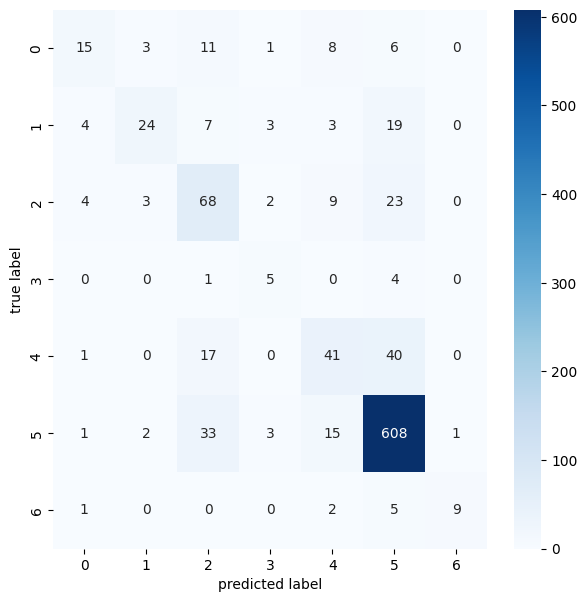

In [40]:
# 예측갑과 정답값의 혼동행렬을 완성해 줍니다.
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (7,7))
cm = confusion_matrix(train_true, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [41]:
# 예측갑과 정답값의 혼동행렬을 완성해 줍니다.
print(classification_report(train_true,pred))

              precision    recall  f1-score   support

           0       0.58      0.34      0.43        44
           1       0.75      0.40      0.52        60
           2       0.50      0.62      0.55       109
           3       0.36      0.50      0.42        10
           4       0.53      0.41      0.46        99
           5       0.86      0.92      0.89       663
           6       0.90      0.53      0.67        17

    accuracy                           0.77      1002
   macro avg       0.64      0.53      0.56      1002
weighted avg       0.77      0.77      0.76      1002



In [100]:
from PIL import Image
from keras.preprocessing import image
import matplotlib.image as mpimg

In [116]:
def pred(path):
    img=image.load_img(path,target_size=(150,150))
    plt.imshow(img)

    x=image.img_to_array(img)
    images=np.expand_dims(x,axis=0)

    nw_label=['akiec','bcc','bkl','df','mel','nv','vasc']
    print(nw_label)
    classes=model.predict(images,batch_size=10)
    print(classes)
    sym=classes.argmax()
    print(sym)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
[[0. 0. 0. 0. 0. 1. 0.]]
5


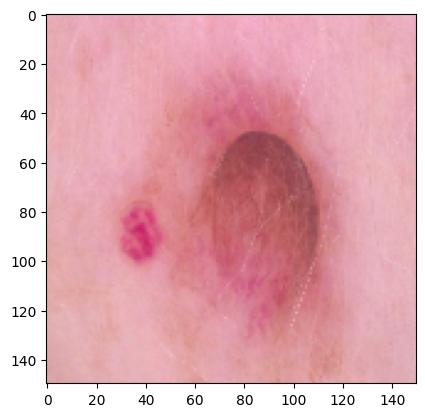

In [121]:
pred(x_test['path'][4155])

In [124]:
def pred(path):
    img=image.load_img(path,target_size=(150,150))
    plt.imshow(img)

    x=image.img_to_array(img)
    images=np.expand_dims(x,axis=0)

    class_name=tile_df['dx'].unique()
    print(class_name)
    classes=model.predict(images,batch_size=7)
    print(classes)

    for i in range(0,7):
        if classes[0][i] ==1.0:
            print("예상판단:",class_name[i])
            break;

    

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
[[0. 0. 0. 0. 0. 1. 0.]]
예상판단: bcc


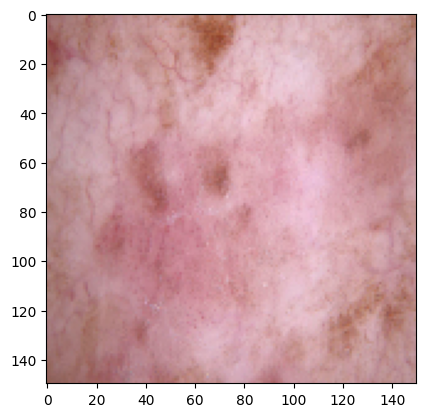

In [127]:
pred(x_test['path'][9699])

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,pred
3025,HAM_0004140,ISIC_0028298,nv,follow_up,45.0,male,upper extremity,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
2399,HAM_0004542,ISIC_0027256,vasc,consensus,0.0,female,back,C:/Users/USER/skin_cancer\HAM10000_images_part...,Vascular lesions,6,6
1012,HAM_0001735,ISIC_0028587,bkl,consensus,80.0,male,back,C:/Users/USER/skin_cancer\HAM10000_images_part...,Benign keratosis-like lesions,2,2
4157,HAM_0001109,ISIC_0027636,nv,follow_up,60.0,male,trunk,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
9676,HAM_0002554,ISIC_0032102,nv,consensus,30.0,male,back,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
...,...,...,...,...,...,...,...,...,...,...,...
5342,HAM_0001029,ISIC_0024384,nv,follow_up,35.0,male,lower extremity,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
3394,HAM_0006671,ISIC_0027843,nv,follow_up,60.0,male,lower extremity,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
4553,HAM_0006087,ISIC_0032094,nv,follow_up,45.0,male,back,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
5007,HAM_0006322,ISIC_0030309,nv,follow_up,55.0,male,foot,C:/Users/USER/skin_cancer\HAM10000_images_part...,Melanocytic nevi,5,5
